### Activamos multi-threading en VSCode con JupyterNotebook

+ [https://docs.julialang.org/en/v1/manual/multi-threading/](https://docs.julialang.org/en/v1/manual/multi-threading/)
+ [https://enccs.github.io/Julia-for-HPC/multithreading/](https://enccs.github.io/Julia-for-HPC/multithreading/)
+ [https://stackoverflow.com/questions/71596187/changing-threads-in-settings-json-of-vs-code-for-julias-jupyter-notebooks](https://stackoverflow.com/questions/71596187/changing-threads-in-settings-json-of-vs-code-for-julias-jupyter-notebooks)

Con el siguiente comando podemos consultar los número de threads disponibles para multithreads, para ello, fue necesario configurar directamente desde VSCode los parámetros de threads para Julia desde JupyterNotebook.

In [414]:
println("Number of threads = ", Threads.nthreads());

Number of threads = 4


# Desarrollo numérico para resolver la ecuación de Schrödinger dependiente del tiempo mediante el método implícito

## 1. Importamos módulo con funciones, parámetros y algorítmos útiles

In [415]:
include("../modules/module_schrodinger_equation_testing_03.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie`


VARIABLES GLOBALES:
m=1.0000 (mass)
ω=1.0000 (frecuency)
ħ=1.0000 (Planck constant)
γ=0.1000 (coupling)
x₁=0.0000 x₂=2.0000f (QHO origin position)


## 2. Definimos propiedades de la grilla y resolvemos problema de autovalores

Acá resolvemos el problema de autovalores para el hamiltoniano individual $\hat{h}_{x_{a}}( x) \phi ( x) =\lambda \phi ( x)$. Entonces, tendremos una ecuación similar de Sturm-Liouville con parámetros $p(x)$,$q(x)$,$r(x)$ definidos como,

\begin{align}
    \begin{cases}
    p( x) =\frac{\hbar^{2}}{2m}\\
    q( x) =\left(\frac{m\omega ^{2}( x-x_{a})^{2}}{2} +\gamma \right)\\
    r( x) =1
    \end{cases} \Rightarrow \left[ -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q( x)\right] u( x) =\lambda r( x) u( x)
\end{align}

Las formas bilineales para considerar el problema débil de autovalores serán de la forma

\begin{align}
        a( u,v) &:= \int _{\Omega }[ p( x) \nabla v( x) \cdotp \nabla u( x) +q( x) v( x) u( x)] d\Omega \\
        b( u,v) &:= \int _{\Omega } r( x) u( x) v( x) d\Omega
\end{align}

aquí las funciones Test $v(x)$ y Trial $u(x)$ viven cada una en un espacio complejo.

Acá la idea es crear la grilla 1D con propiedades de tamaño de elementos finitos y condiciones de borde (de tipo Dirichlet homogeneas). Además, resolvemos el problema de autovalores para el hamiltoniano del oscilador armónico $\hat {h}_{x_0=0}(x)$ y calculamos las autoenergías y autoestados útiles para contruir la condición inicial en el problema de evolución.

In [416]:
grid_type="simple_line";                            # tipo de grilla
Δxₕ=1.0/50.0;                                      # tamaño del elento 1D

dom_1D=(-25.0,25.0);

par_1D=(path_models,grid_type*"_01",dom_1D,Δxₕ);    # (path,name,dom,MeshSize)

model_1D=make_model(grid_type,par_1D);              # creamos modelo
write_data=true
if write_data
    writevtk(model_1D,path_images*"model_1D");      # escribimos el modelo para visualizar con Visit
end

# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[(0.0+im*0.0),(0.0+im*0.0)]; # tipo Dirichlet homogeneas en los bordes

Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);

reffe_1D=reference_FEspaces(lagrangian,Float64,2);

Vₕ_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕ_1D=TrialFESpace(Vₕ_1D,dirichlet_values_1D);

aₕ_1D,bₕ_1D=bilineal_forms(pₕ,qₕ,rₕ,dΩ_1D);

nevₕ=20 # number of eigenvalues asked to evaluate.
probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-9),maxiter=500,explicittransform=:none,sigma=-1.0)
ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.00187619s, CPU 0.001876s)
Info    : 2501 nodes 2502 elements
Info    : Writing '../outputs/Output_Testing_03_SignleEigenProblemAndImplicitMethod/models/simple_line_01.msh'...
Info    : Done writing '../outputs/Output_Testing_03_SignleEigenProblemAndImplicitMethod/models/simple_line_01.msh'
Info    : Reading '../outputs/Output_Testing_03_SignleEigenProblemAndImplicitMethod/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 2501 nodes
Info    : 2502 elements
Info    : Done reading '../outputs/Output_Testing_03_SignleEigenProblemAndImplicitMethod/models/simple_line_01.msh'


In [417]:
# Escribimos autovectores para visualizar externamente
write_data=true;
if write_data
    for i in 1:nevₕ
        ϕₕi_1D = ϕₕ_1D[i]; # autovector asociado al autovalor 6
        writevtk(Ω_1D,path_images*"eigenprob_1D_01_num$(i)",cellfields=["phi_real" => real(ϕₕi_1D), "phi_imag" => real(ϕₕi_1D)]);
    end
end

> useful links to embeded mp4 inside Markdown Julia
 + [https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video)
 + [https://www.freeconvert.com/mpeg-to-mp4](https://www.freeconvert.com/mpeg-to-mp4)

## 3. Resolvemos la ecuación de evolución (ecuación de Schrödinger dependiente del tiempo) con método de Euler implícito

Tendremos el siguiente sistema de ecuaciones a resolver,

\begin{align}
     \begin{array}{l}
    \begin{pmatrix}
    \{2\hat{I} -[ \alpha \hat{A} +\alpha _{1}( x_{i})] \Delta t\} & -\beta \Delta t\\
    -\beta \Delta t & \{2\hat{I} -[ \alpha \hat{A} +\alpha _{2}( x_{i})] \Delta t\}
    \end{pmatrix}\begin{pmatrix}
    u_{1}( x_{i} ,t+\Delta t)\\
    u_{2}( x_{i} ,t+\Delta t)
    \end{pmatrix} =\\
    \begin{pmatrix}
    \{2\hat{I} +[ \alpha \hat{A} +\alpha _{1}( x_{i})] \Delta t\} & \beta \Delta t\\
    \beta \Delta t & \{2\hat{I} +[ \alpha \hat{A} +\alpha _{2}( x_{i})] \Delta t\}
    \end{pmatrix}\begin{pmatrix}
    u_{1}( x_{i} ,t)\\
    u_{2}( x_{i} ,t)
    \end{pmatrix}
    \end{array}
\end{align}

Y las formas tensoriales débiles para este caso serán

\begin{align}
    \begin{array}{l}
    a_{1}(( u_{1} ,u_{2}) ,v_{1}) := \int _{\Omega }\{2( u_{1} v_{1}) -[ -\alpha ( \nabla v_{1} \cdotp \nabla u_{1}) +\alpha _{1}( u_{1} v_{1}) +\beta ( u_{2} v_{1})] \Delta t\} d\Omega \\
    a_{2}(( u_{2} ,u_{1}) ,v_{2}) := \int _{\Omega }\{2( u_{2} v_{2}) -[ -\alpha ( \nabla v_{2} \cdotp \nabla u_{2}) +\alpha _{2}( u_{2} v_{2}) +\beta ( u_{1} v_{2})] \Delta t\} d\Omega \\
    \\
    \Rightarrow a(( u_{1} ,v_{1}) ,( u_{2} ,v_{2})) := a_{1}(( u_{1} ,u_{2}) ,v_{1}) +a_{2}(( u_{2} ,u_{1}) ,v_{2})\\
    \\
    \\
    b_{1}( v_{1}) := \int _{\Omega }\left\{2\left( u_{1}^{0} v_{1}\right) +\left[ -\alpha \left( \nabla v_{1} \cdotp \nabla u_{1}^{0}\right) +\alpha _{1}\left( u_{1}^{0} v_{1}\right) +\beta \left( u_{2}^{0} v_{1}\right)\right] \Delta t\right\} d\Omega \\
    b_{2}( v_{2}) := \int _{\Omega }\left\{2\left( u_{2}^{0} v_{2}\right) +\left[ -\alpha \left( \nabla v_{2} \cdotp \nabla u_{2}^{0}\right) +\alpha _{2}\left( u_{2}^{0} v_{2}\right) +\beta \left( u_{1}^{0} v_{2}\right)\right] \Delta t\right\} d\Omega \\
    \\
    \Rightarrow b( v_{1} ,v_{2}) := b_{1}( v_{1}) +b_{2}( v_{2})
    \end{array}
\end{align}

y resolveremos una ecuación del tipo

\begin{align}
    a(( u_{1} ,v_{1}) ,( u_{2} ,v_{2}))\vec{u}( x_{i} ,t_{j}) =b( v_{1} ,v_{2}) \Rightarrow \boxed{\vec{u}( x_{i} ,t_{j}) =\left( a^{-1}\right) b}
\end{align}

y tendremos que resolver un problema de inversión de matrices. Aquí, la forma bilineal $b(v_1,v_2)$ deberá actualizarse en cada paso evolucionado con un nuevo par inicial $\vec{u}^{0} =\left( u_{1}^{0} ,u_{2}^{0}\right)$.

### 3.1. Definimos variables temporales

In [449]:
scale_factor_fs = 0.02418884
t₀=0.0;t₁=100;                    # final time for test
num_steps=700001;                     # number of time steps   
n_int=35000;                           # Intervals where data is saved n_int=(num_steps-1)/20
Δt=abs(t₁-t₀)*(1.0/(num_steps-1))   # time step

0.00014285714285714287

Aquí mostramos factores de interes, como ser:
+ El factor $\frac {\Delta t}{\Delta x^2}$ nos permite corroborar que, si es pequeño $( \lt 1)$, el método de Euler usual funcionaría.
+ El factor $\frac {\Delta t}{\Delta x}$ si es aproximadamente igual a 1, y no usamos métodos implícitos, el método explícito sería intestable.
+ El factor $\left ( \frac {\Delta t}{\Delta x^2} \right)^3$ nos dice cómo escala el error del método implícito.

In [419]:
@printf("Δt/Δx²=%.6f\nΔt/Δx=%.6f\nΔt³/Δx⁶=%.6f",Δt/(Δxₕ^2),(Δt/Δxₕ),(Δt/(Δxₕ^2))^3)

Δt/Δx²=0.357143
Δt/Δx=0.007143
Δt³/Δx⁶=0.045554

### 3.2. Construimos espacios Trial y Test
Como resolvemos la evolución en componentes de la función de onda, tendremos que construir espacios Test y Trial de tipo `MultiFieldFESpace()`.

In [420]:
# espacio de pruebas y de soluciones para ψ₁
V₁H_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₁H_1D=TrialFESpace(V₁H_1D,dirichlet_values_1D);
# espacio de pruebas y de soluciones para ψ₂
V₂H_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₂H_1D=TrialFESpace(V₂H_1D,dirichlet_values_1D);
# creamos un campo de espacios
UH_1D = MultiFieldFESpace([U₁H_1D, U₂H_1D]);
VH_1D = MultiFieldFESpace([V₁H_1D, V₂H_1D]);

### 3.3. Construimos la condición inicial

Para construir la condición inicial utilizamos la función de interpolación para crear objetos en un dominio específico, es decir, en el dominio del hamiltoniano $\hat {h}_{x_0=0}(x)$, e interpolamos en otro domino específico, es decir, en el dominio del hamiltoniano del sistema $\hat {H}(x)$. De esta forma creamos una condición inicial donde una de las componentes sea la autofunción del hamiltoniano individual $\hat {h}_{x_0=0}(x)$.

In [421]:
u₀ₕ_1D=interpolate_everywhere(ϕₕ_1D[1],Uₕ_1D);
interp_u₀ₕ_1D=Interpolable(u₀ₕ_1D);

In [422]:
type_BC=1;
if (type_BC==1)
    u₁0H_1D_v₁(x)=0.0;
    u₂0H_1D_v₁=interpolate_everywhere(interp_u₀ₕ_1D,U₂H_1D);
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₁,u₂0H_1D_v₁],UH_1D);
elseif (type_BC==2)
    u₁0H_1D_v₂=interpolate_everywhere(interp_u₀ₕ_1D,U₁H_1D);
    u₂0H_1D_v₂(x)=0.0;
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₂,u₂0H_1D_v₂],UH_1D);
end

MultiFieldFEFunction():
 num_cells: 2500
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 11782429701909130256

Si es requerido podemos escribir datos en formato vtk para visualizar externamente.

In [423]:
write_data=true
if write_data
    writevtk(Ω_1D,path_images*"evol_ini_dat_$(lpad(0,3,'0'))", cellfields=["u10H_2D_re"=>real(u₀H_1D[1]),"u10H_2D_im"=>imag(u₀H_1D[1])])
end

(["../outputs/Output_Testing_03_SignleEigenProblemAndImplicitMethod/images/evol_ini_dat_000.vtu"],)

Mostramos norma $L_2$ de las coordenadas de la condición inicial para asegurarnos sus propiedades.

In [424]:
@printf("norm L₂u₁=%.6f,norm L₂u₂=%.6f",norm_L2(u₀H_1D[1],dΩ_1D),norm_L2(u₀H_1D[2],dΩ_1D))

norm L₂u₁=0.000000,norm L₂u₂=1.000000

### 3.4. Definimos forma bilineal $a((u_1,u_2),(v_1,v_2))$ y matriz principal A

In [425]:
a_H_1D=a_bilineal_forms_2D(α₁,α₂,Δt,dΩ_1D);

assem_H=SparseMatrixAssembler(UH_1D,VH_1D);       # ensamblamos una matriz sparse con U y V
dv_H=get_fe_basis(VH_1D);                         # escribimos v en la base de FE de V            
du_H=get_trial_fe_basis(UH_1D);                   # escribimos u en la base de FE de U
mat_contribs_H=a_H_1D(du_H,dv_H);                       # creamos una matriz de bases (contribuciones)
data_H=collect_cell_matrix(UH_1D,VH_1D,mat_contribs_H); # recolectamos una matriz (datos)
A_H=assemble_matrix(assem_H,data_H);                    # creamos matriz A con contribuciones y datos

Creamos una función para obtener los puntos discretos de la grilla (valuados) y un vector de dichos puntos, lo cual será útil para graficar los resultados o realizar cálculos específicos

In [426]:
function space_coord(dom,Δx)
    x=[dom[1]+abs(dom[2]-dom[1])*Δx*i for i in 1:convert(Int,1.0/Δx)];
    pts=[Point(x[i]) for i in 1:convert(Int,1.0/Δx)];
    return x,pts;
end

function normalization_eigenstates_2D(ϕ,TrialSpace,dΩ)
    nom_vec₁₂=zeros(Float64,length(ϕ))
    for i in 1:length(ϕ)
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        norm_ϕ¹ᵢ=norm_L2(ϕ¹ᵢ,dΩ)
        norm_ϕ²ᵢ=norm_L2(ϕ²ᵢ,dΩ)
        nom_vec₁₂[i]=norm_ϕ¹ᵢ+norm_ϕ²ᵢ
    end
    return nom_vec₁₂;
end

normalization_eigenstates_2D (generic function with 1 method)

In [427]:
x,pts=space_coord(dom_1D,Δxₕ);

Realizamos la evolución, definiendo en cada paso el funcional b(v) y haciendo uso del operador backslash `\` para diagonalizar

In [428]:
time_vec=[t₀+Δt*(i-1) for i in 1:n_int:(num_steps-1)];    # vector de tiempos

In [429]:
𝛹ₓₜ=Vector{CellField}(undef,length(time_vec));  # función de onda

In [430]:
# inicializamos en cero el vector de onda
uₓₜ=interpolate_everywhere(u₀H_1D,UH_1D);
u¹ₓₜ,u²ₓₜ=uₓₜ;
for i in 1:length(time_vec)
    𝛹ₓₜ[i]=interpolate_everywhere([0.0*u¹ₓₜ,0.0*u²ₓₜ],UH_1D)
end

In [431]:
index=1;
# paso inicial (t=0)
t=time_vec[index];

# guardamos función de onda
uₓₜ=interpolate_everywhere(u₀H_1D,UH_1D);
u¹ₓₜ,u²ₓₜ=uₓₜ;
𝛹ₓₜ[index]=interpolate_everywhere([u¹ₓₜ,u²ₓₜ],UH_1D)

norm_switch=true
if norm_switch
    Norm𝛹ₓₜ=normalization_eigenstates_2D(𝛹ₓₜ,UH_1D,dΩ_1D)
    𝛹ₓₜ¹=interpolate_everywhere(𝛹ₓₜ[index],UH_1D)
    𝛹¹ₓₜ¹,𝛹²ₓₜ¹=𝛹ₓₜ¹
    𝛹ₓₜ[index]=interpolate_everywhere([𝛹¹ₓₜ¹/Norm𝛹ₓₜ[index],𝛹²ₓₜ¹/Norm𝛹ₓₜ[index]],UH_1D)

    # actualizamos condición inicial normalizada
    u₀H_1D=𝛹ₓₜ[index];
end

# escribimos datos vtk para visualizar externamente
write_data=true;
if write_data
  writevtk(Ω_1D,path_images*"evol_1D_02_$(lpad(index,3,'0'))",
  cellfields=["u1H_1D_re" => real(𝛹ₓₜ[index][1]), "u1H_1D_im" => imag(𝛹ₓₜ[index][1]),"u2H_1D_re" => real(𝛹ₓₜ[index][2]), "u2H_1D_im" => imag(𝛹ₓₜ[index][2])])
  @printf("t=%.6f,norm L₂u₁=%.6f,norm L₂u₂=%.6f\n",t,norm_L2(𝛹ₓₜ[index][1],dΩ_1D),norm_L2(𝛹ₓₜ[index][2],dΩ_1D))
end

t=0.000000,norm L₂u₁=0.000000,norm L₂u₂=1.000000


Definimos una nueva función para normalizar autoestados, pero cuando se trata de una única función de elemtos finitos (no vectorial)

In [432]:
function normalization_eigenstates_2D_FEFunction(ϕ,TrialSpace,dΩ)
    ϕᵢ=interpolate_everywhere(ϕ,TrialSpace);
    ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
    norm_ϕ¹ᵢ=norm_L2(ϕ¹ᵢ,dΩ)
    norm_ϕ²ᵢ=norm_L2(ϕ²ᵢ,dΩ)
    nom_vec₁₂=norm_ϕ¹ᵢ+norm_ϕ²ᵢ
    return nom_vec₁₂;
end

normalization_eigenstates_2D_FEFunction (generic function with 1 method)

In [433]:
# evolucionamos para t>0
for i in 1:(num_steps-2)
  # construimos forma bilineal b(v₁,v₂)
  b_H_1D=b_bilineal_form_2D(α₁,α₂,u₀H_1D[1],u₀H_1D[2],Δt,dΩ_1D)

  # descomentar si queremos resolver de forma usual
  # vec_contribs_H=b_H_1D(dv_H[1],dv_H[2])
  vec_contribs_H=b_H_1D(dv_H)
  data_H=collect_cell_vector(VH_1D,vec_contribs_H)
  b_H=assemble_vector(assem_H,data_H)
  x_H = A_H \ b_H
  uH_1D = FEFunction(UH_1D,x_H)

  # descomentar si queremos resolver con solver (NO FUNCIONA)
  # op = Affineassem_HFEOperator(a_H_1D,b_H_1D,UH_1D,VH_1D)
  # ls=LUSolver();solver=LinearFESolver(ls)
  # uH_1D = solve(solver,op)

  # actualizamos condición inicial
  if norm_switch
    # normalizamos la función de onda luego de cada evolución
    Norm_uH_1D=normalization_eigenstates_2D_FEFunction(uH_1D,UH_1D,dΩ_1D)
    uH¹²_1D=interpolate_everywhere(uH_1D,UH_1D)
    uH¹_1D,uH²_1D=uH¹²_1D
    u₀H_1D=interpolate_everywhere([uH¹_1D/Norm_uH_1D,uH²_1D/Norm_uH_1D],UH_1D)
  else
    u₀H_1D=uH_1D
  end

  if (i % n_int == 0)
    index+=1;
    t = time_vec[index];
    
    # guardamos función de onda
    uₓₜ=interpolate_everywhere(u₀H_1D,UH_1D);
    u¹ₓₜ,u²ₓₜ=uₓₜ;
    𝛹ₓₜ[index]=interpolate_everywhere([u¹ₓₜ,u²ₓₜ],UH_1D)

    # escribimos datos vtk para visualizar externamente
    if write_data
      writevtk(Ω_1D,path_images*"evol_1D_02_$(lpad(index,3,'0'))",
      cellfields=["u1H_1D_re" => real(𝛹ₓₜ[index][1]), "u1H_1D_im" => imag(𝛹ₓₜ[index][1]),"u2H_1D_re" => real(𝛹ₓₜ[index][2]), "u2H_1D_im" => imag(𝛹ₓₜ[index][2])])
      @printf("t=%.6f,norm L₂u=%.6f\n",t,(norm_L2(𝛹ₓₜ[index][1],dΩ_1D)+norm_L2(𝛹ₓₜ[index][2],dΩ_1D)))
    end
  end
end

t=5.000000,norm L₂u=1.000000
t=10.000000,norm L₂u=1.000000


t=15.000000,norm L₂u=1.000000
t=20.000000,norm L₂u=1.000000


t=25.000000,norm L₂u=1.000000
t=30.000000,norm L₂u=1.000000


t=35.000000,norm L₂u=1.000000
t=40.000000,norm L₂u=1.000000


t=45.000000,norm L₂u=1.000000
t=50.000000,norm L₂u=1.000000


t=55.000000,norm L₂u=1.000000
t=60.000000,norm L₂u=1.000000


t=65.000000,norm L₂u=1.000000
t=70.000000,norm L₂u=1.000000


t=75.000000,norm L₂u=1.000000
t=80.000000,norm L₂u=1.000000


t=85.000000,norm L₂u=1.000000
t=90.000000,norm L₂u=1.000000


t=95.000000,norm L₂u=1.000000


Chequeamos normalización de los autoestados

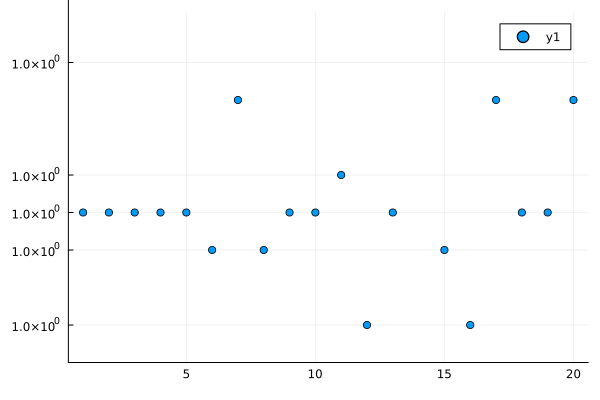

In [434]:
𝛹ₓₜ_norm=normalization_eigenstates_2D(𝛹ₓₜ,UH_1D,dΩ_1D);
scatter(𝛹ₓₜ_norm)

┌ Info: Saved animation to 
│   fn = /tmp/jl_9ARUNmL0pU.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_9ARUNmL0pU.gif")
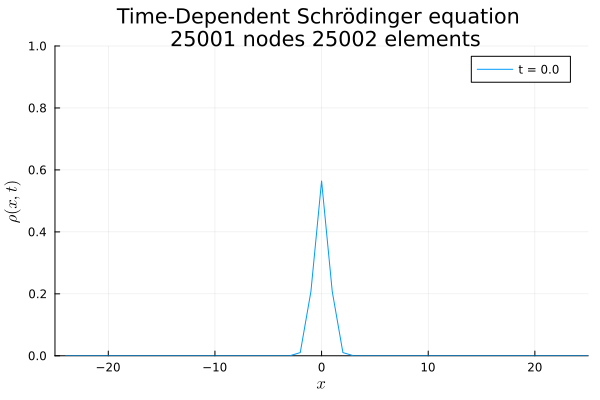

In [435]:
anim₁ = @animate for i in 1:length(time_vec)
    ρ₁Hreim_1D=real(conj(𝛹ₓₜ[i][1].(pts)).*𝛹ₓₜ[i][1].(pts)) #./ (𝛹ₓₜ_norm[i]^2)
    ρ₂Hreim_1D=real(conj(𝛹ₓₜ[i][2].(pts)).*𝛹ₓₜ[i][2].(pts)) #./ (𝛹ₓₜ_norm[i]^2)

    plot(x[:],ρ₁Hreim_1D+ρ₂Hreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-25,25))
    # plot(x[:],ρ₁Hreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-10,10))
    plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-25,25))
end

gif(anim₁, fps = 1)

### Mostramos salida de Densidad de probabilidad con visualizador Visit

<video controls width="500">
  <source src="./videos/pseudocolor_density1D_v3.mp4" type="video/mp4" />
</video>


Notemos que, a pesar de la poca resolución espacial que tomamos, con el visualizador Visit logra interpolar la función correctamente, dandonos una forma funcional más suave

Una vez obtenido el operador densidad podremos calcular las probabilidades de que una dada partícula esté en un volumen $V$ para un dado tiempo $t$ de la siguiente manera,

\begin{align}
    p( t) =\int _{V} \rho (\vec{x} ,t) dV
\end{align}

y numéricamente tendremos

\begin{align}
    p_{k}( t_{j}) =\mathrm{sum}\left(\int _{\Omega }[ u_{k}( x_{i} ,t_{j})]^{*} u_{k}( x_{i} ,t_{j}) d\Omega \right) ;\ k=\{1,2\}
\end{align}

$^{\ddagger }$ Wikipedia contributors, "Probability amplitude," Wikipedia, The Free Encyclopedia, https://en.wikipedia.org/w/index.php?title=Probability_amplitude&oldid=1120547317 (accessed February 11, 2023).

In [446]:
function Populations_2D(𝛹ₓₜ,TrialSpace,dΩ)
    dimₜ=length(𝛹ₓₜ)
    p¹ₜ=zeros(Float64,dimₜ);
    p²ₜ=zeros(Float64,dimₜ);

    for i in 1:dimₜ
        𝛹ₓₜᵢ=interpolate_everywhere(𝛹ₓₜ[i],TrialSpace);
        𝛹¹ₓₜᵢ,𝛹²ₓₜᵢ=𝛹ₓₜᵢ
        norm_𝛹¹ₓₜᵢ=norm_L2(𝛹¹ₓₜᵢ,dΩ)
        norm_𝛹²ₓₜᵢ=norm_L2(𝛹²ₓₜᵢ,dΩ)
        (norm_𝛹¹ₓₜᵢ ≠ 0.0) ? p¹ₜ[i]=real(sum(∫(𝛹¹ₓₜᵢ'*𝛹¹ₓₜᵢ)*dΩ))/(norm_𝛹¹ₓₜᵢ) : p¹ₜ[i]=0.0
        (norm_𝛹²ₓₜᵢ ≠ 0.0) ? p²ₜ[i]=real(sum(∫(𝛹²ₓₜᵢ'*𝛹²ₓₜᵢ)*dΩ))/(norm_𝛹²ₓₜᵢ) : p²ₜ[i]=0.0
    end

    return p¹ₜ,p²ₜ;
end

Populations_2D (generic function with 1 method)

In [451]:
p₁H_1D,p₂H_1D=Populations_2D(𝛹ₓₜ,UH_1D,dΩ_1D); # calculamos poblaciones

# escribimos datos vtk para visualizar externamente
write_data=true
if write_data
    for index in 1:length(p₁H_1D)
        writevtk(Ω_1D,path_images*"population_1D_$(lpad(index,3,'0'))",
        cellfields=["p1H_1D" => p₁H_1D[index], "p2H_1D" => p₂H_1D[index]])
    end
end

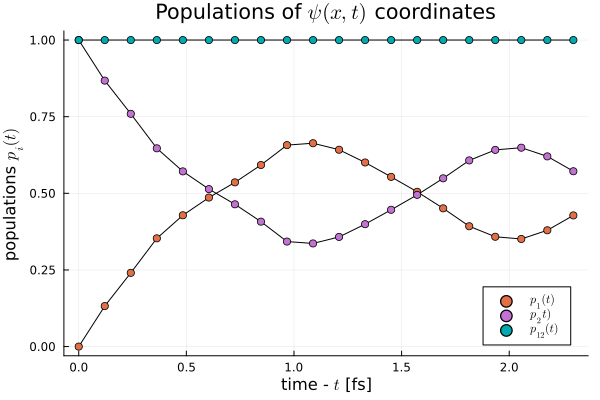

In [452]:
plotting=true
if plotting
    using Interpolations
    plot1=plot(time_vec .* scale_factor_fs,p₁H_1D,label="",lw=1,lc="black")
    plot1=scatter!(time_vec .* scale_factor_fs,p₁H_1D,label="\$p_{1}(t)\$")
    plot1=plot!(time_vec .* scale_factor_fs,p₂H_1D,label="",lw=1,lc=:"black")
    plot1=scatter!(time_vec .* scale_factor_fs,p₂H_1D,label="\$p_{2}t)\$")
    plot1=plot!(time_vec .* scale_factor_fs,(p₁H_1D .+ p₂H_1D),label="",lw=1,lc=:"black")
    plot1=scatter!(time_vec .* scale_factor_fs,(p₁H_1D .+ p₂H_1D),label="\$p_{12}(t)\$")
    plot1=plot!(title="Populations of \$\\psi(x,t)\$ coordinates",xlabel="time - \$t\$ [fs]",ylabel="populations \$p_{i}(t)\$")
    plot1=plot!(legend=:bottomright)

    display(plot1);
    savefig(plot1,path_plots*"population_wfcoord.pdf");
end

### Resultados obtenidos usando MCTDH

<video controls width="500">
  <source src="./videos/MCTDH_simulation_screencast.mp4" type="video/mp4" />
</video>

Mostramos resultados de las poblaciones obtenidos con paquete MCTDH

In [1]:
import Pkg; Pkg.add("PGFPlotsX");

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
# Create a PDF struct that can be showed as inline svg
using PGFPlotsX

struct PDF
    file::String
    PDF(file) = new(abspath(file))
end
function Base.show(io::IO, ::MIME"image/svg+xml", pdf::PDF)
    svg = first(splitext(pdf.file)) * ".svg"
    #svg = splitext(pdf.file) * ".svg"
    PGFPlotsX.convert_pdf_to_svg(pdf.file, svg)
    write(io, read(svg))
    try; rm(svg; force=true); catch e; end
    return nothing
end

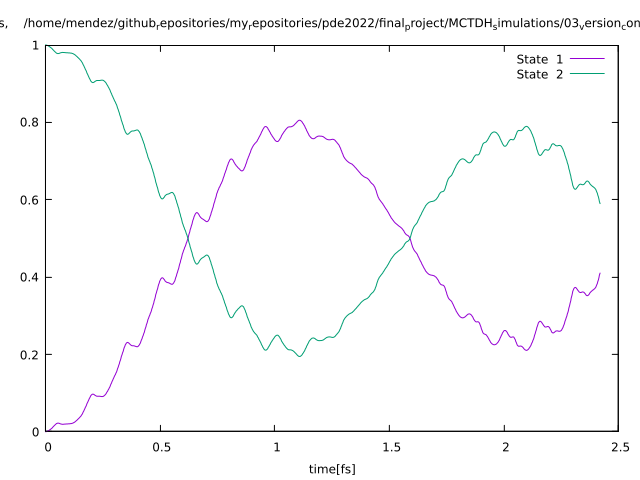

In [3]:
PDF("../MCTDH_simulations/03_version_components/plots/populatios_plstate.pdf")